# Mini‑proyecto ML (Clasificación) — Banknote Authentication (UCI) — **Versión sencilla y muy clara**

**Objetivo:** construir un *pipeline* de clasificación **tradicional** y **didáctico** con 4 modelos:
**KNN, SVM, Árbol de Decisión y Random Forest**.  
Priorizamos **claridad de código** frente a evitar repeticiones.

**Dataset:** UCI Banknote Authentication — estadísticas (wavelet) de imágenes de billetes.  
**Target:** `class` (0 = auténtico, 1 = falso).

---

## Guía de la libreta
1. Instalación opcional de dependencias.  
2. Carga de datos desde **una** URL y EDA mínima.  
3. División *train/test* (sin estratificar, por simplicidad).  
4. Experimentos **por separado** para cada modelo (sin bucles ni *helpers*):  
   - Preparación (escalado solo donde conviene)  
   - Definición del modelo  
   - Búsqueda de hiperparámetros con `GridSearchCV` (rejillas pequeñas)  
   - Entrenamiento y **reporte de métricas** (accuracy, precision, recall, F1, ROC‑AUC, PR‑AUC), matriz de confusión, curvas ROC y PR.  
5. Discusión detallada de **hiperparámetros** y **rangos típicos**.

> Nota: el código es **intencionadamente repetitivo** para que cada bloque sea legible de forma aislada.


## 1) Instalación opcional de dependencias

In [ ]:
# !pip -q install numpy pandas scikit-learn matplotlib

## 2) Imports y configuración

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, roc_curve,
                             precision_recall_curve, ConfusionMatrixDisplay, classification_report)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 3) Carga del dataset (UNA URL) y EDA mínima
Usamos la URL original de UCI (CSV sin cabecera). Si alguna vez no funcionase, **cambia tú la URL** aquí.


Dimensiones: (1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0



Tipos:
variance    float64
skewness    float64
curtosis    float64
entropy     float64
class         int64
dtype: object

Nulos por columna:
variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Distribución de la clase (0=auténtico, 1=falso):
class
0    0.555394
1    0.444606
Name: ratio, dtype: float64


,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
skewness,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
curtosis,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
class,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


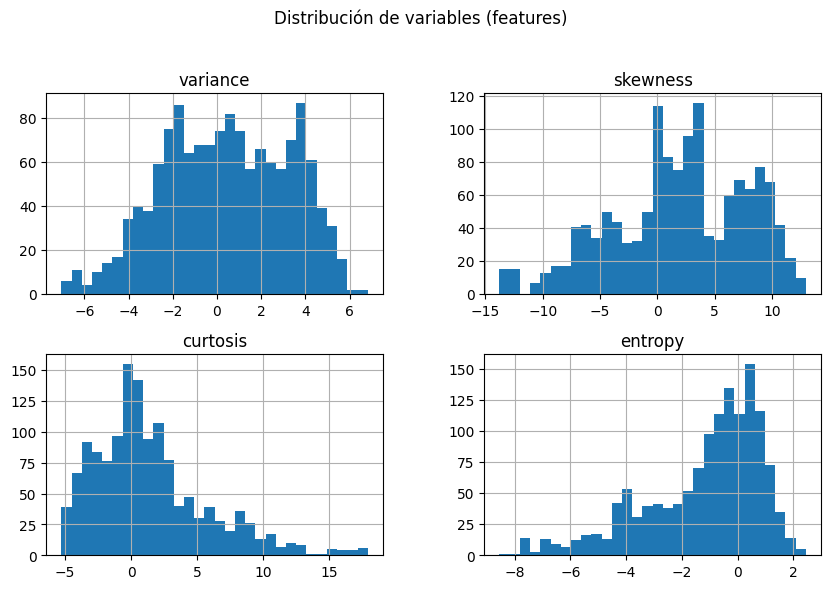

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
cols = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df = pd.read_csv(url, header=None, names=cols)

print('Dimensiones:', df.shape)
display(df.head())
print('\nTipos:')
print(df.dtypes)
print('\nNulos por columna:')
print(df.isna().sum())

print('\nDistribución de la clase (0=auténtico, 1=falso):')
print(df['class'].value_counts(normalize=True).rename('ratio'))

display(df.describe().T)

df.drop(columns=['class']).hist(bins=30, figsize=(10,6))
plt.suptitle('Distribución de variables (features)', y=1.02)
plt.show()

## 4) Train/Test split (sin estratificar, por simplicidad)
> Nota: en casos reales, con clases desbalanceadas, **sí** conviene estratificar.


In [3]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print('Train shape:', X_train.shape, ' Test shape:', X_test.shape)

Train shape: (1097, 4)  Test shape: (275, 4)


# 5) Modelo 1 — KNN (k-Nearest Neighbors)

### ¿Cuándo usar escalado?
KNN usa distancias, así que **escalamos** las *features* para que todas estén en la misma magnitud.


In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_curve

scaler_knn = StandardScaler()
X_train_knn = scaler_knn.fit_transform(X_train)
X_test_knn = scaler_knn.transform(X_test)

knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

gs_knn = GridSearchCV(knn, param_grid_knn, scoring='f1', cv=5, n_jobs=-1, refit=True)
gs_knn.fit(X_train_knn, y_train)

print('Mejor F1 (cv):', round(gs_knn.best_score_, 3))
print('Mejores params:', gs_knn.best_params_)

Mejor F1 (cv): 0.998
Mejores params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [ ]:
best_knn = gs_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_knn)
y_score_knn = best_knn.predict_proba(X_test_knn)[:, 1]

acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn, zero_division=0)
rec = recall_score(y_test, y_pred_knn, zero_division=0)
f1 = f1_score(y_test, y_pred_knn, zero_division=0)
rocauc = roc_auc_score(y_test, y_score_knn)
prauc = average_precision_score(y_test, y_score_knn)

print('KNN — Métricas test')
print(f'Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}')
print(f'ROC-AUC: {rocauc:.3f}  PR-AUC: {prauc:.3f}\n')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, display_labels=['Auténtico (0)','Falso (1)'])
plt.title('KNN — Matriz de confusión'); plt.grid(False); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_score_knn)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label='KNN')
plt.plot([0,1],[0,1],'--', linewidth=1); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('KNN — ROC'); plt.legend(); plt.grid(True); plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_score_knn)
plt.figure(figsize=(6,5)); plt.plot(recall, precision, label='KNN')
baseline = (y_test==1).mean()
plt.hlines(baseline, 0, 1, linestyles='--')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('KNN — Precision-Recall'); plt.legend(); plt.grid(True); plt.show()

print(classification_report(y_test, y_pred_knn, digits=3))

# 6) Modelo 2 — SVM (SVC con kernel RBF)

### Escalado
SVM también se beneficia del **escalado** de *features*.

> Nota: activamos `probability=True` para obtener probabilidades (necesario para ROC/PR).

In [ ]:
scaler_svm = StandardScaler()
X_train_svm = scaler_svm.fit_transform(X_train)
X_test_svm = scaler_svm.transform(X_test)

svm = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)

param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

gs_svm = GridSearchCV(svm, param_grid_svm, scoring='f1', cv=5, n_jobs=-1, refit=True)
gs_svm.fit(X_train_svm, y_train)

print('Mejor F1 (cv):', round(gs_svm.best_score_, 3))
print('Mejores params:', gs_svm.best_params_)

In [ ]:
best_svm = gs_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_svm)
y_score_svm = best_svm.predict_proba(X_test_svm)[:, 1]

acc = accuracy_score(y_test, y_pred_svm)
prec = precision_score(y_test, y_pred_svm, zero_division=0)
rec = recall_score(y_test, y_pred_svm, zero_division=0)
f1 = f1_score(y_test, y_pred_svm, zero_division=0)
rocauc = roc_auc_score(y_test, y_score_svm)
prauc = average_precision_score(y_test, y_score_svm)

print('SVM — Métricas test')
print(f'Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}')
print(f'ROC-AUC: {rocauc:.3f}  PR-AUC: {prauc:.3f}\n')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=['Auténtico (0)','Falso (1)'])
plt.title('SVM — Matriz de confusión'); plt.grid(False); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_score_svm)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label='SVM')
plt.plot([0,1],[0,1],'--', linewidth=1); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('SVM — ROC'); plt.legend(); plt.grid(True); plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_score_svm)
plt.figure(figsize=(6,5)); plt.plot(recall, precision, label='SVM')
baseline = (y_test==1).mean()
plt.hlines(baseline, 0, 1, linestyles='--')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('SVM — Precision-Recall'); plt.legend(); plt.grid(True); plt.show()

print(classification_report(y_test, y_pred_svm, digits=3))

# 7) Modelo 3 — Árbol de Decisión

### Escalado
Los árboles **no necesitan** escalado (se basan en umbrales por variable).

In [ ]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid_dt = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

gs_dt = GridSearchCV(dt, param_grid_dt, scoring='f1', cv=5, n_jobs=-1, refit=True)
gs_dt.fit(X_train, y_train)

print('Mejor F1 (cv):', round(gs_dt.best_score_, 3))
print('Mejores params:', gs_dt.best_params_)

In [ ]:
best_dt = gs_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_score_dt = best_dt.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_dt)
prec = precision_score(y_test, y_pred_dt, zero_division=0)
rec = recall_score(y_test, y_pred_dt, zero_division=0)
f1 = f1_score(y_test, y_pred_dt, zero_division=0)
rocauc = roc_auc_score(y_test, y_score_dt)
prauc = average_precision_score(y_test, y_score_dt)

print('Decision Tree — Métricas test')
print(f'Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}')
print(f'ROC-AUC: {rocauc:.3f}  PR-AUC: {prauc:.3f}\n')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, display_labels=['Auténtico (0)','Falso (1)'])
plt.title('Decision Tree — Matriz de confusión'); plt.grid(False); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_score_dt)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label='Decision Tree')
plt.plot([0,1],[0,1],'--', linewidth=1); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Decision Tree — ROC'); plt.legend(); plt.grid(True); plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_score_dt)
plt.figure(figsize=(6,5)); plt.plot(recall, precision, label='Decision Tree')
baseline = (y_test==1).mean()
plt.hlines(baseline, 0, 1, linestyles='--')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Decision Tree — Precision-Recall'); plt.legend(); plt.grid(True); plt.show()

print(classification_report(y_test, y_pred_dt, digits=3))

# 8) Modelo 4 — Random Forest

### Escalado
Tampoco necesita escalado.


In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

gs_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=5, n_jobs=-1, refit=True)
gs_rf.fit(X_train, y_train)

print('Mejor F1 (cv):', round(gs_rf.best_score_, 3))
print('Mejores params:', gs_rf.best_params_)

In [ ]:
best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_score_rf = best_rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, zero_division=0)
rec = recall_score(y_test, y_pred_rf, zero_division=0)
f1 = f1_score(y_test, y_pred_rf, zero_division=0)
rocauc = roc_auc_score(y_test, y_score_rf)
prauc = average_precision_score(y_test, y_score_rf)

print('Random Forest — Métricas test')
print(f'Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}')
print(f'ROC-AUC: {rocauc:.3f}  PR-AUC: {prauc:.3f}\n')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=['Auténtico (0)','Falso (1)'])
plt.title('Random Forest — Matriz de confusión'); plt.grid(False); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_score_rf)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0,1],[0,1],'--', linewidth=1); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Random Forest — ROC'); plt.legend(); plt.grid(True); plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_score_rf)
plt.figure(figsize=(6,5)); plt.plot(recall, precision, label='Random Forest')
baseline = (y_test==1).mean()
plt.hlines(baseline, 0, 1, linestyles='--')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Random Forest — Precision-Recall'); plt.legend(); plt.grid(True); plt.show()

print(classification_report(y_test, y_pred_rf, digits=3))

## 9) Hiperparámetros — ¿Qué hacen y qué rangos tienen sentido?

### KNN
- **`n_neighbors (k)`**: nº de vecinos a considerar.  
  - Pequeño (3–5): fronteras muy detalladas, **menos bias** y **más varianza** (sensible a ruido).  
  - Grande (7–25): fronteras suaves, **más bias** y **menos varianza**.  
  - Regla práctica: probar varios impares para evitar empates.
- **`weights`**: `'uniform'` (todos igual) vs `'distance'` (cercanos pesan más).  
  - `'distance'` suele mejorar cuando hay densidades desiguales o outliers.
- **`p`** (Minkowski): `p=2` (Euclídea) es estándar; `p=1` (Manhattan) puede ser más robusta a outliers.
- **Consejo**: siempre **escalar** antes de KNN.

---

### SVM (SVC con kernel RBF)
- **`C`** (penalización): controla cuánto penalizamos errores en entrenamiento.  
  - **Grande** (10, 100): margen estrecho, bajo bias, riesgo de **overfit**.  
  - **Pequeño** (0.1, 0.01): margen amplio, más bias, más **regularización**.
- **`gamma`**: alcance de la influencia de cada punto.  
  - **Alto**: regiones muy locales (sobreajuste).  
  - **Bajo**: regiones suaves (infra‑ajuste).  
  - `'scale'` suele ser una buena base.
- **Consejo**: **escalar** siempre.

---

### Decision Tree
- **`max_depth`**: límite de profundidad.   
  - `None` (sin límite) → riesgo de overfit; 3–20 típicos según datos.
- **`min_samples_leaf`**: ejemplos mínimos por hoja; subirlo suaviza y reduce varianza (2–10 razonable).
- **`min_samples_split`**: mínimo para dividir un nodo; subirlo evita splits con muy pocos datos.
- **`criterion`**: `'gini'` o `'entropy'` (rendimientos similares).

---

### Random Forest
- **`n_estimators`**: nº de árboles; 100–300 suele bastar (más = menos varianza y más coste).  
- **`max_depth`/`min_samples_leaf`**: controlan complejidad por árbol (evitan overfit).  
- **`max_features`**: nº de *features* consideradas por split; `'sqrt'` es muy común en clasificación.
- **Importancias**: permiten ver qué variables aportan más (no es causalidad).

---

### Métricas — recordatorio rápido
- **Accuracy** (acierto global) — bien con clases balanceadas.  
- **Precision** (evitar FP), **Recall** (evitar FN), **F1** (equilibrio).  
- **ROC‑AUC** (ranking global de puntuaciones) y **PR‑AUC** (mejor con clases raras).

> En casos reales: ajustar **umbral**, calibrar probabilidades y analizar errores por tipo.
